## LightGBM

Abrimos el dataset en el cual ya hemos trabajado las nuevas variables y caracteristicas.<br><br>
NOTAS:<br>
- algunas no fraude eliminar
- generar
- eliminar y aumentar
- matriz de confusión (clase objetivo) (clase 2)

In [44]:
#!pip install lightgbm
#!pip install --upgrade lightgbm
#!pip install category_encoders
#!pip install geopy

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import logging
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


In [46]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [47]:
data = pd.read_csv('final_dataset.csv')
data

,trans_date_trans_time,cc_num,merchant,category,amt,lat,long,trans_num,unix_time,merch_lat,...,yearly_txn_count_by_cat,season,seasonal_txn_count_by_cat,time_diff_hours,transaction_speed,amt_to_daily_avg,amt_to_monthly_avg,txn_count_last_hour,new_merchant,amt_to_annual_avg
0,2019-01-03 01:39:04,180011453250192,"fraud_Huel, Hammes and Witting",grocery_pos,90.37,41.2153,-90.9879,96a9fd4073d93d59eca9622dc21802c4,1325554744,41.810204,...,1,Winter,1,NaN,0.000000,0.225391,0.804453,1.0,True,0.925752
1,2019-01-03 05:51:22,180011453250192,fraud_Huel-Langworth,misc_net,108.09,41.2153,-90.9879,04cf40b2f392f3932b2532a92f1ef538,1325569882,41.016419,...,1,Winter,1,4.0,11.951459,0.269586,0.962193,1.0,True,1.107276
2,2019-01-03 14:48:47,180011453250192,fraud_Lemke and Sons,travel,447.52,41.2153,-90.9879,90d74d1a15d29a250fedbabe6721a483,1325602127,41.734914,...,1,Winter,1,8.0,8.712667,1.116156,3.983721,1.0,True,4.584404
3,2019-01-04 10:39:10,180011453250192,"fraud_Christiansen, Goyette and Schamberger",gas_transport,73.17,41.2153,-90.9879,52f1b4392482195579c35df07514962a,1325673550,40.744024,...,1,Winter,1,19.0,3.096099,0.182493,0.651343,1.0,True,0.749555
4,2019-01-04 12:48:21,180011453250192,fraud_Ruecker-Mayert,kids_pets,47.55,41.2153,-90.9879,63954f859ede83d209aece226970441b,1325681301,41.462258,...,1,Winter,1,2.0,41.738353,0.118594,0.423279,1.0,True,0.487103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 14:49:51,676372984911,fraud_Kris-Padberg,shopping_pos,6.13,39.7562,-98.4462,e327aa916b4317b8baf9d181855bf9df,1388501391,39.553152,...,145,Winter,96,3.0,24.693907,0.019995,0.087796,1.0,False,0.094527
1852390,2020-12-31 16:17:19,676372984911,fraud_Schiller Ltd,personal_care,62.99,39.7562,-98.4462,2d10acccfe94d134bdac9c41c614cb00,1388506639,40.024226,...,145,Winter,95,1.0,34.733267,0.205466,0.902169,1.0,False,0.971327
1852391,2020-12-31 20:21:23,676372984911,fraud_Pollich LLC,home,28.11,39.7562,-98.4462,24ffee6f547efdbffcf471498e55e0eb,1388521283,40.412189,...,195,Winter,88,4.0,21.983892,0.091692,0.402603,1.0,False,0.433466
1852392,2020-12-31 20:58:25,676372984911,"fraud_Hayes, Marquardt and Dibbert",misc_net,211.32,39.7562,-98.4462,898279ea0067e89917bdf288f96d6834,1388523505,40.240147,...,91,Winter,36,0.0,inf,0.689301,3.026613,2.0,False,3.258625


In [48]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'lat',
       'long', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'time_since_last_txn', 'avg_daily_amt', 'hour',
       'avg_hourly_transactions', 'prev_lat', 'prev_long',
       'distance_from_last_txn', 'month_year', 'monthly_spending_variation',
       'weekday', 'is_holiday', 'first_txn_time', 'days_since_first_txn',
       'txn_count_last_24h', 'avg_amt_last_24h', 'std_amt_last_24h',
       'online_txn_ratio', 'trans_date', 'monthly_txn_count_by_cat',
       'trans_year', 'yearly_txn_count_by_cat', 'season',
       'seasonal_txn_count_by_cat', 'time_diff_hours', 'transaction_speed',
       'amt_to_daily_avg', 'amt_to_monthly_avg', 'txn_count_last_hour',
       'new_merchant', 'amt_to_annual_avg'],
      dtype='object')

Vamos a convertir aquellas columnas que no sean datos numericos con un encoder

In [49]:
columns_to_encode = ['merchant', 'category', 'season']

with open('label_encodings.txt', 'w') as file:
    for col in columns_to_encode:
        encoder = LabelEncoder()
        data[col + '_encoded'] = encoder.fit_transform(data[col])
        mappings = {index: label for index, label in enumerate(encoder.classes_)}
        file.write(f"{col} mappings:\n")
        for key, value in mappings.items():
            file.write(f"{key}: {value}\n")
        file.write("\n")

data.drop(columns=columns_to_encode, axis=1, inplace=True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 47 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   amt                           float64
 3   lat                           float64
 4   long                          float64
 5   trans_num                     object 
 6   unix_time                     int64  
 7   merch_lat                     float64
 8   merch_long                    float64
 9   is_fraud                      int64  
 10  amt_month                     float64
 11  amt_year                      float64
 12  amt_month_shopping_net_spend  float64
 13  count_month_shopping_net      float64
 14  first_time_at_merchant        bool   
 15  time_since_last_txn           float64
 16  avg_daily_amt                 float64
 17  hour                          int64  
 18  avg_hourly_transaction

In [51]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'amt', 'lat', 'long', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'amt_month',
       'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net',
       'first_time_at_merchant', 'time_since_last_txn', 'avg_daily_amt',
       'hour', 'avg_hourly_transactions', 'prev_lat', 'prev_long',
       'distance_from_last_txn', 'month_year', 'monthly_spending_variation',
       'weekday', 'is_holiday', 'first_txn_time', 'days_since_first_txn',
       'txn_count_last_24h', 'avg_amt_last_24h', 'std_amt_last_24h',
       'online_txn_ratio', 'trans_date', 'monthly_txn_count_by_cat',
       'trans_year', 'yearly_txn_count_by_cat', 'seasonal_txn_count_by_cat',
       'time_diff_hours', 'transaction_speed', 'amt_to_daily_avg',
       'amt_to_monthly_avg', 'txn_count_last_hour', 'new_merchant',
       'amt_to_annual_avg', 'merchant_encoded', 'category_encoded',
       'season_encoded'],
      dtype='object')

Observamos detalladamente por aquellas columnas que no son numéricas que pueden necesitas codificación:

In [52]:
non_numeric_columns = data.select_dtypes(include=['object']).columns

print("Columnas no numéricas que podrían necesitar codificación:")
non_numeric_columns

Columnas no numéricas que podrían necesitar codificación:


Index(['trans_date_trans_time', 'trans_num', 'month_year', 'first_txn_time',
       'trans_date'],
      dtype='object')

Ahora vamos a generar los sub datasets donde la información de cada mes será agrupada en un solo set para poder hacer entrenamiento incremental por mes.

In [53]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.set_index('trans_date_trans_time', inplace=True)

In [54]:
monthly_groups = data.groupby(pd.Grouper(freq='M'))
monthly_datasets = {}
for name, group in monthly_groups:
    print(f"Datos para el mes: {name}")
    monthly_datasets[name] = group
    print(group.head())
    print("\n-------------------------------------------\n")


Datos para el mes: 2019-01-31 00:00:00
                                 cc_num     amt      lat      long  \
trans_date_trans_time                                                
2019-01-01 00:00:18    2703186189652095    4.97  36.0788  -81.1781   
2019-01-01 00:00:44        630423337322  107.23  48.8878 -118.2105   
2019-01-01 00:00:51      38859492057661  220.11  42.1808 -112.2620   
2019-01-01 00:01:16    3534093764340240   45.00  46.2306 -112.1138   
2019-01-01 00:03:06     375534208663984   41.96  38.4207  -79.4629   

                                              trans_num   unix_time  \
trans_date_trans_time                                                 
2019-01-01 00:00:18    0b242abb623afc578575680df30655b9  1325376018   
2019-01-01 00:00:44    1f76529f8574734946361c461b024d99  1325376044   
2019-01-01 00:00:51    a1a22d70485983eac12b5b88dad1cf95  1325376051   
2019-01-01 00:01:16    6b849c168bdad6f867558c3793159a81  1325376076   
2019-01-01 00:03:06    a41d7549acf90789359a9

In [55]:
data.reset_index(inplace=True)
data

,trans_date_trans_time,cc_num,amt,lat,long,trans_num,unix_time,merch_lat,merch_long,is_fraud,...,time_diff_hours,transaction_speed,amt_to_daily_avg,amt_to_monthly_avg,txn_count_last_hour,new_merchant,amt_to_annual_avg,merchant_encoded,category_encoded,season_encoded
0,2019-01-03 01:39:04,180011453250192,90.37,41.2153,-90.9879,96a9fd4073d93d59eca9622dc21802c4,1325554744,41.810204,-91.411125,0,...,NaN,0.000000,0.225391,0.804453,1.0,True,0.925752,270,4,3
1,2019-01-03 05:51:22,180011453250192,108.09,41.2153,-90.9879,04cf40b2f392f3932b2532a92f1ef538,1325569882,41.016419,-90.483090,0,...,4.0,11.951459,0.269586,0.962193,1.0,True,1.107276,271,8,3
2,2019-01-03 14:48:47,180011453250192,447.52,41.2153,-90.9879,90d74d1a15d29a250fedbabe6721a483,1325602127,41.734914,-91.455863,0,...,8.0,8.712667,1.116156,3.983721,1.0,True,4.584404,385,13,3
3,2019-01-04 10:39:10,180011453250192,73.17,41.2153,-90.9879,52f1b4392482195579c35df07514962a,1325673550,40.744024,-91.307026,0,...,19.0,3.096099,0.182493,0.651343,1.0,True,0.749555,92,2,3
4,2019-01-04 12:48:21,180011453250192,47.55,41.2153,-90.9879,63954f859ede83d209aece226970441b,1325681301,41.462258,-91.929837,0,...,2.0,41.738353,0.118594,0.423279,1.0,True,0.487103,537,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 14:49:51,676372984911,6.13,39.7562,-98.4462,e327aa916b4317b8baf9d181855bf9df,1388501391,39.553152,-99.268462,0,...,3.0,24.693907,0.019995,0.087796,1.0,False,0.094527,341,12,3
1852390,2020-12-31 16:17:19,676372984911,62.99,39.7562,-98.4462,2d10acccfe94d134bdac9c41c614cb00,1388506639,40.024226,-98.655599,0,...,1.0,34.733267,0.205466,0.902169,1.0,False,0.971327,551,10,3
1852391,2020-12-31 20:21:23,676372984911,28.11,39.7562,-98.4462,24ffee6f547efdbffcf471498e55e0eb,1388521283,40.412189,-99.023856,0,...,4.0,21.983892,0.091692,0.402603,1.0,False,0.433466,481,6,3
1852392,2020-12-31 20:58:25,676372984911,211.32,39.7562,-98.4462,898279ea0067e89917bdf288f96d6834,1388523505,40.240147,-98.681613,0,...,0.0,inf,0.689301,3.026613,2.0,False,3.258625,235,8,3


In [56]:
columns_to_remove = ['trans_date_trans_time', 'month_year', 'first_txn_time', 'trans_date', 'cc_num', 'trans_num', 'unix_time']
for month, dataset in monthly_datasets.items():
    # Eliminar columnas no deseadas que existen en el dataset
    existing_columns_to_remove = [col for col in columns_to_remove if col in dataset.columns]
    if existing_columns_to_remove:
        dataset.drop(columns=existing_columns_to_remove, inplace=True)

    # Convertir tipos de datos
    for col in dataset.columns:
        if dataset[col].dtype == 'object':  # Conversión de object a float si contiene solo números
            try:
                dataset[col] = dataset[col].astype(float)
            except ValueError:
                dataset[col] = dataset[col].astype('category')  # Convierte a categoría si no puede ser float

        elif dataset[col].dtype == 'bool':
            dataset[col] = dataset[col].astype(int)

    # Reasignar el dataset procesado al diccionario
    monthly_datasets[month] = dataset

    # Imprimir los tipos de datos para verificar
    print(f"Tipos de datos para el mes: {month.strftime('%Y-%m')}")
    print(dataset.dtypes)
    print("\n-------------------------------------------\n")


C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns=existing_columns_to_remove, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[col] = dataset[col].astype(int)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Tipos de datos para el mes: 2019-01
amt                             float64
lat                             float64
long                            float64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
amt_month                       float64
amt_year                        float64
amt_month_shopping_net_spend    float64
count_month_shopping_net        float64
first_time_at_merchant            int32
time_since_last_txn             float64
avg_daily_amt                   float64
hour                              int64
avg_hourly_transactions         float64
prev_lat                        float64
prev_long                       float64
distance_from_last_txn          float64
monthly_spending_variation      float64
weekday                           int64
is_holiday                        int32
days_since_first_txn              int64
txn_count_last_24h              float64
avg_amt_last_24h                float64
std_

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[col] = dataset[col].astype(int)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns=existing_columns_to_remove, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1462488418.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [57]:
for month, dataset in monthly_datasets.items():
    valid_types = all(dtype in [np.number, np.bool_] for dtype in dataset.dtypes)
    if not valid_types:
        print(f"El dataset para {month.strftime('%Y-%m')} contiene tipos no válidos para LGBM.")
    else:
        print(f"El dataset para {month.strftime('%Y-%m')} está listo para LGBM.")


El dataset para 2019-01 contiene tipos no válidos para LGBM.
El dataset para 2019-02 contiene tipos no válidos para LGBM.
El dataset para 2019-03 contiene tipos no válidos para LGBM.
El dataset para 2019-04 contiene tipos no válidos para LGBM.
El dataset para 2019-05 contiene tipos no válidos para LGBM.
El dataset para 2019-06 contiene tipos no válidos para LGBM.
El dataset para 2019-07 contiene tipos no válidos para LGBM.
El dataset para 2019-08 contiene tipos no válidos para LGBM.
El dataset para 2019-09 contiene tipos no válidos para LGBM.
El dataset para 2019-10 contiene tipos no válidos para LGBM.
El dataset para 2019-11 contiene tipos no válidos para LGBM.
El dataset para 2019-12 contiene tipos no válidos para LGBM.
El dataset para 2020-01 contiene tipos no válidos para LGBM.
El dataset para 2020-02 contiene tipos no válidos para LGBM.
El dataset para 2020-03 contiene tipos no válidos para LGBM.
El dataset para 2020-04 contiene tipos no válidos para LGBM.
El dataset para 2020-05 

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\2165270538.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  valid_types = all(dtype in [np.number, np.bool_] for dtype in dataset.dtypes)


In [58]:
# Revisar los tipos de datos de cada dataset mensual
for month, dataset in monthly_datasets.items():
    print(f"Tipos de datos para el mes: {month.strftime('%Y-%m')}")
    print(dataset.dtypes)  # Mostrar los tipos de datos
    print("\n-------------------------------------------\n")

Tipos de datos para el mes: 2019-01
amt                             float64
lat                             float64
long                            float64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
amt_month                       float64
amt_year                        float64
amt_month_shopping_net_spend    float64
count_month_shopping_net        float64
first_time_at_merchant            int32
time_since_last_txn             float64
avg_daily_amt                   float64
hour                              int64
avg_hourly_transactions         float64
prev_lat                        float64
prev_long                       float64
distance_from_last_txn          float64
monthly_spending_variation      float64
weekday                           int64
is_holiday                        int32
days_since_first_txn              int64
txn_count_last_24h              float64
avg_amt_last_24h                float64
std_

In [59]:
for month, dataset in monthly_datasets.items():
    for column in dataset.columns:
        if dataset[column].dtype == 'int64' or dataset[column].dtype == 'int32':
            dataset[column] = dataset[column].astype(float)
        elif dataset[column].dtype == 'bool':
            dataset[column] = dataset[column].astype(int)  # Convertir booleanos a enteros

    monthly_datasets[month] = dataset

for month, dataset in monthly_datasets.items():
    for column in dataset.columns:
        if dataset[column].dtype == 'int64' or dataset[column].dtype == 'int32':
            dataset[column] = dataset[column].astype(float)
        elif dataset[column].dtype == 'bool':
            dataset[column] = dataset[column].astype(int)  # Convertir booleanos a enteros

    monthly_datasets[month] = dataset


C:\Users\marco\AppData\Local\Temp\ipykernel_81912\1365510585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].astype(float)


In [60]:
# Revisar los tipos de datos de cada dataset mensual
for month, dataset in monthly_datasets.items():
    print(f"Tipos de datos para el mes: {month.strftime('%Y-%m')}")
    print(dataset.dtypes)  # Mostrar los tipos de datos
    print("\n-------------------------------------------\n")

Tipos de datos para el mes: 2019-01
amt                             float64
lat                             float64
long                            float64
merch_lat                       float64
merch_long                      float64
is_fraud                        float64
amt_month                       float64
amt_year                        float64
amt_month_shopping_net_spend    float64
count_month_shopping_net        float64
first_time_at_merchant          float64
time_since_last_txn             float64
avg_daily_amt                   float64
hour                            float64
avg_hourly_transactions         float64
prev_lat                        float64
prev_long                       float64
distance_from_last_txn          float64
monthly_spending_variation      float64
weekday                         float64
is_holiday                      float64
days_since_first_txn            float64
txn_count_last_24h              float64
avg_amt_last_24h                float64
std_

Procedemos a separar el dataset en 80% entrenamiento y 20% validación.

In [61]:
for month, dataset in monthly_datasets.items():
    null_counts = dataset.isnull().sum()
    print(f"Valores null para el mes: {month.strftime('%Y-%m')}")
    print(null_counts)

    dataset.fillna(0.0, inplace=True)

    monthly_datasets[month] = dataset
    print("\n-------------------------------------------\n")

Valores null para el mes: 2019-01
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn               913
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                          913
prev_long                         913
distance_from_last_txn              0
monthly_spending_variation      52525
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_last_24h                 8064
online_txn_ratio

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True

Valores null para el mes: 2019-04
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 5
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            5
prev_long                           5
distance_from_last_txn              0
monthly_spending_variation         44
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_last_24h                 6093
online_txn_ratio

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True


-------------------------------------------

Valores null para el mes: 2019-07
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 2
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            2
prev_long                           2
distance_from_last_txn              0
monthly_spending_variation         15
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True

Valores null para el mes: 2019-09
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 5
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            5
prev_long                           5
distance_from_last_txn              0
monthly_spending_variation         51
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_last_24h                 6078
online_txn_ratio

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True


-------------------------------------------

Valores null para el mes: 2020-01
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 3
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            3
prev_long                           3
distance_from_last_txn              0
monthly_spending_variation         29
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True


-------------------------------------------

Valores null para el mes: 2020-05
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 7
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            7
prev_long                           7
distance_from_last_txn              0
monthly_spending_variation         67
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True


-------------------------------------------

Valores null para el mes: 2020-08
amt                                 0
lat                                 0
long                                0
merch_lat                           0
merch_long                          0
is_fraud                            0
amt_month                           0
amt_year                            0
amt_month_shopping_net_spend        0
count_month_shopping_net            0
first_time_at_merchant              0
time_since_last_txn                 0
avg_daily_amt                       0
hour                                0
avg_hourly_transactions             0
prev_lat                            0
prev_long                           0
distance_from_last_txn              0
monthly_spending_variation          0
weekday                             0
is_holiday                          0
days_since_first_txn                0
txn_count_last_24h                  0
avg_amt_last_24h                    0
std_amt_

C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_81912\3820363029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)


### Entrenamiento con LGBM

Entrenando con datos de: 2019-01-31 00:00:00
Entrenando con datos de: 2019-02-28 00:00:00
Entrenando con datos de: 2019-03-31 00:00:00
Entrenando con datos de: 2019-04-30 00:00:00
Entrenando con datos de: 2019-05-31 00:00:00
Entrenando con datos de: 2019-06-30 00:00:00
Entrenando con datos de: 2019-07-31 00:00:00
Entrenando con datos de: 2019-08-31 00:00:00
Entrenando con datos de: 2019-09-30 00:00:00
Entrenando con datos de: 2019-10-31 00:00:00
Entrenando con datos de: 2019-11-30 00:00:00
Entrenando con datos de: 2019-12-31 00:00:00
Entrenando con datos de: 2020-01-31 00:00:00
Entrenando con datos de: 2020-02-29 00:00:00
Entrenando con datos de: 2020-03-31 00:00:00
Entrenando con datos de: 2020-04-30 00:00:00
Entrenando con datos de: 2020-05-31 00:00:00
Entrenando con datos de: 2020-06-30 00:00:00
Entrenando con datos de: 2020-07-31 00:00:00
Entrenando con datos de: 2020-08-31 00:00:00


C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Entrenando con datos de: 2020-09-30 00:00:00


C:\Users\marco\AppData\Local\Temp\ipykernel_81912\2461295598.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Entrenando con datos de: 2020-10-31 00:00:00
Entrenando con datos de: 2020-11-30 00:00:00
Entrenando con datos de: 2020-12-31 00:00:00
Revisa la carpeta 'model_performance_charts' para ver el desempeño de los modelos.


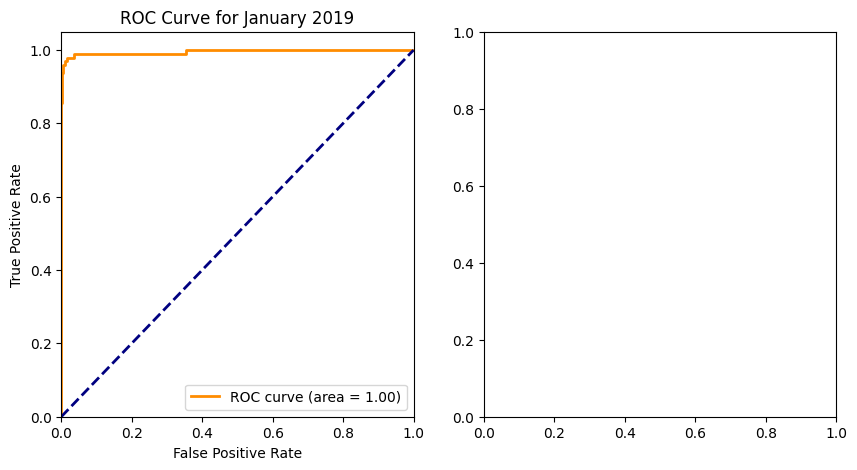

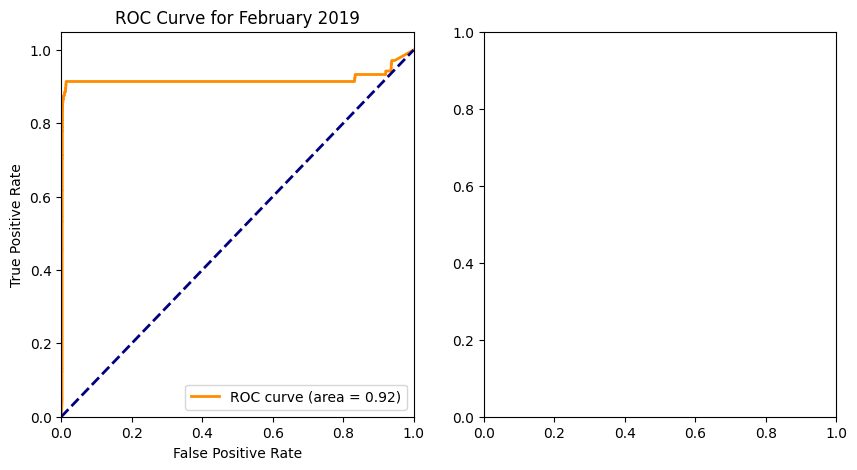

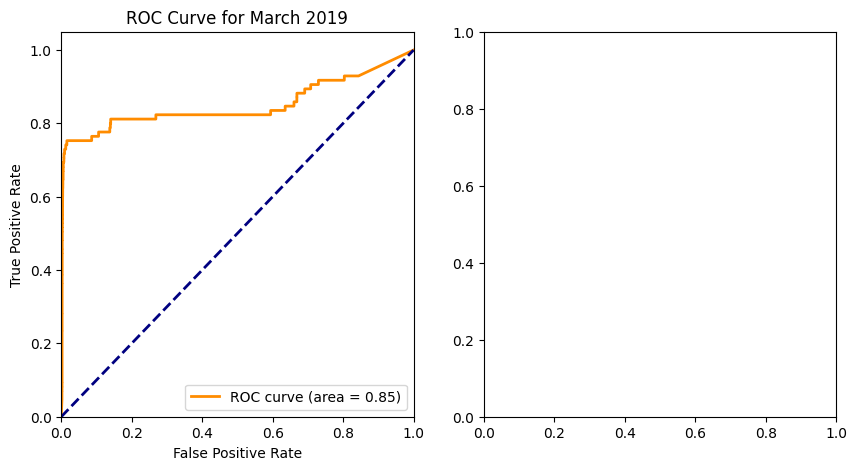

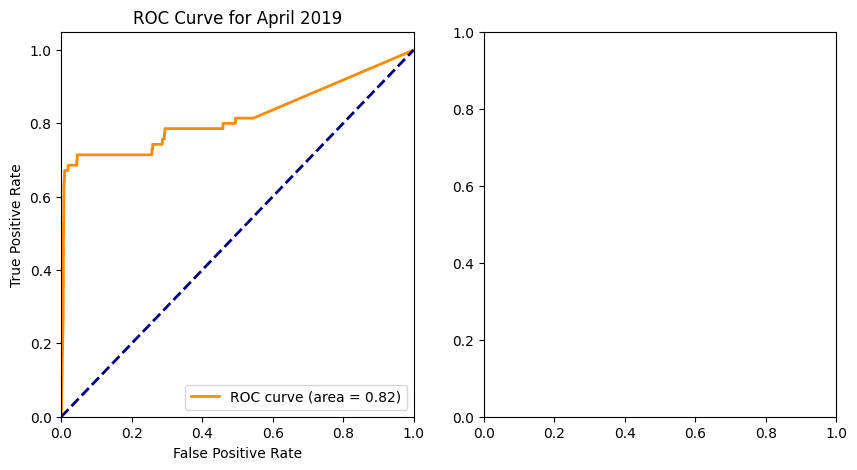

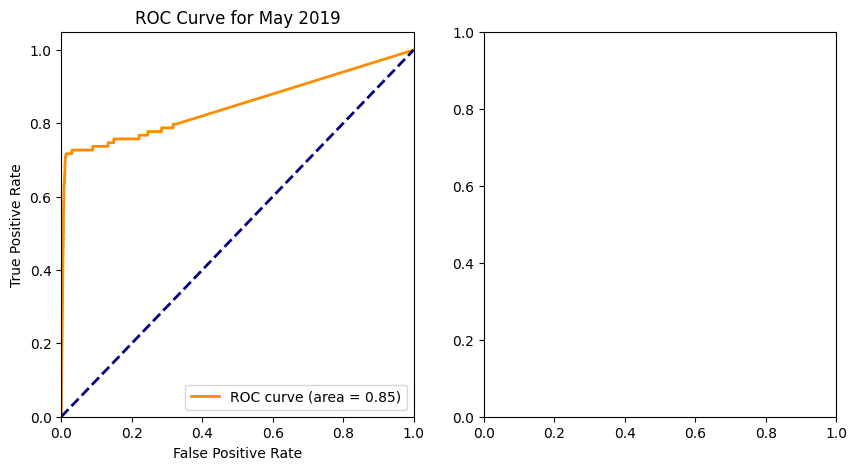

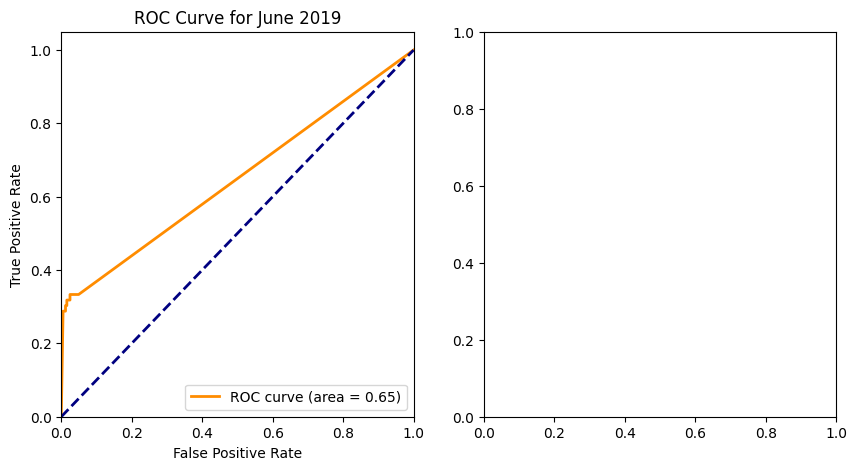

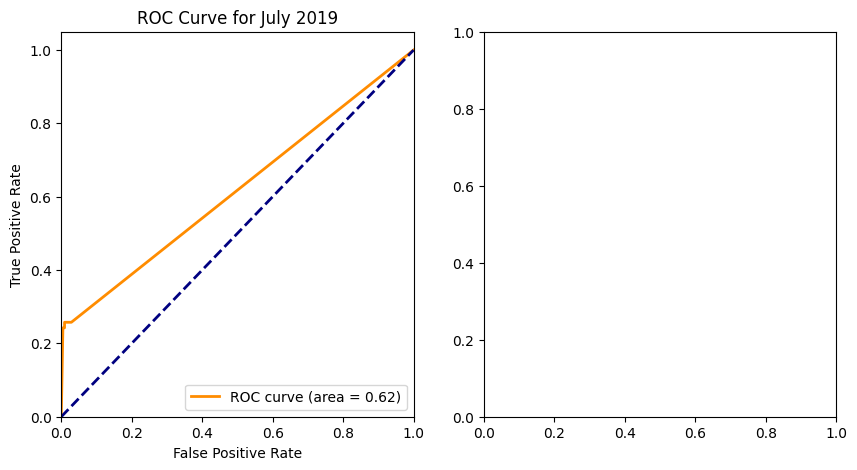

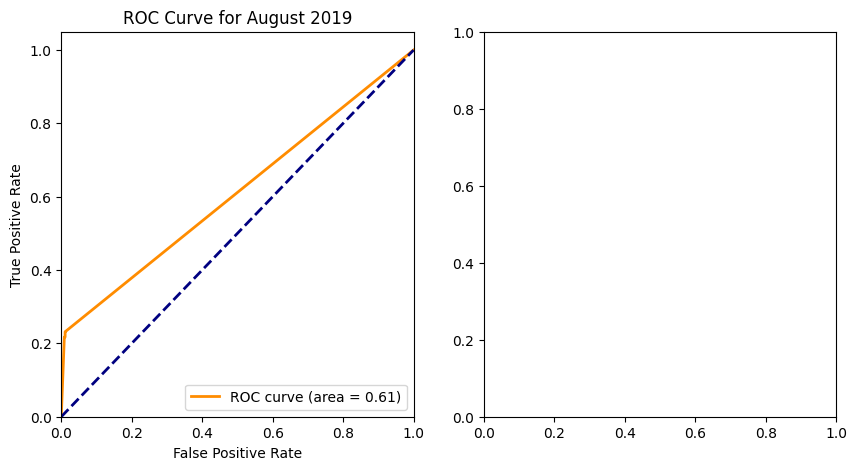

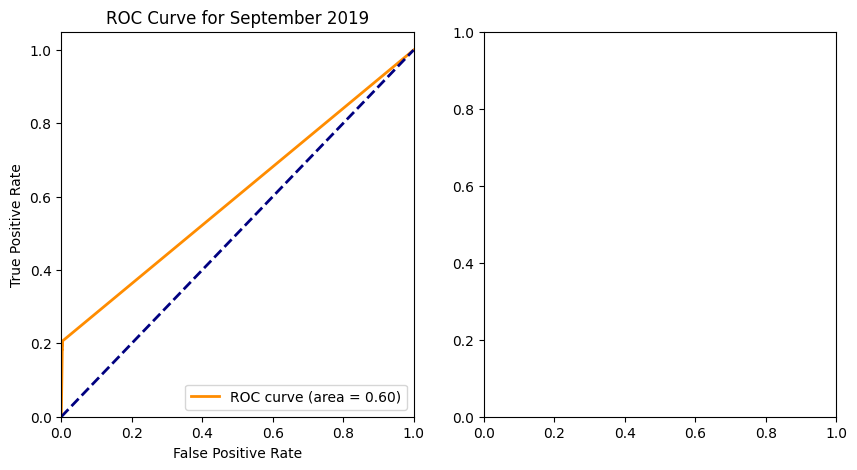

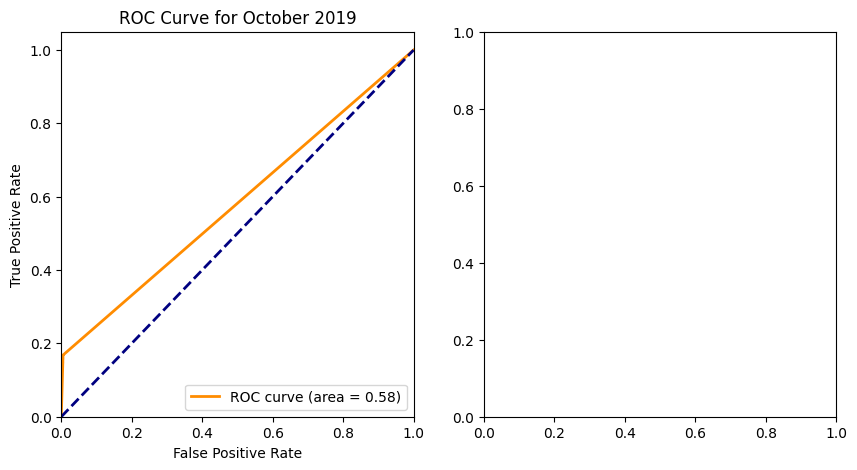

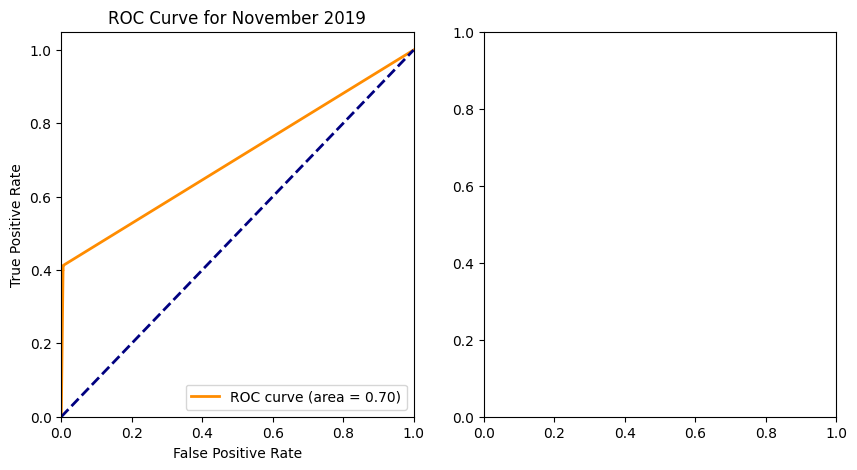

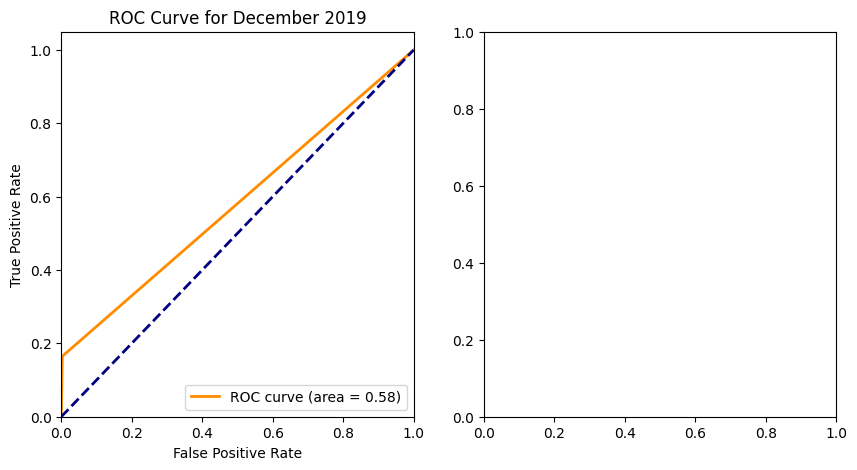

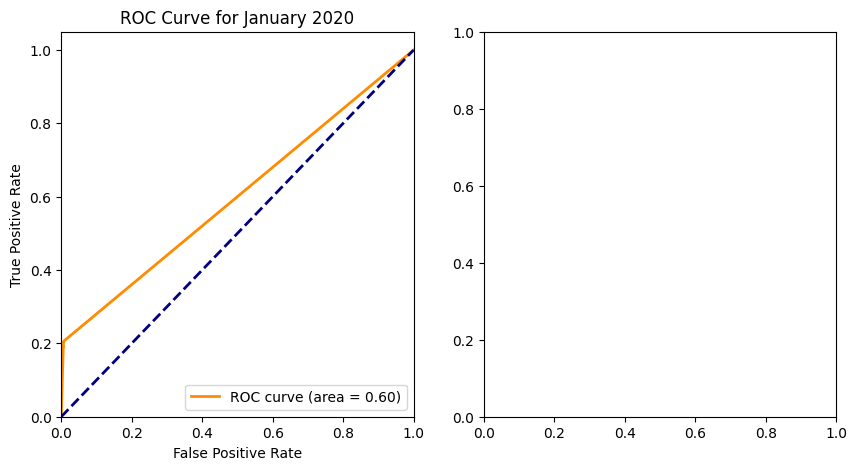

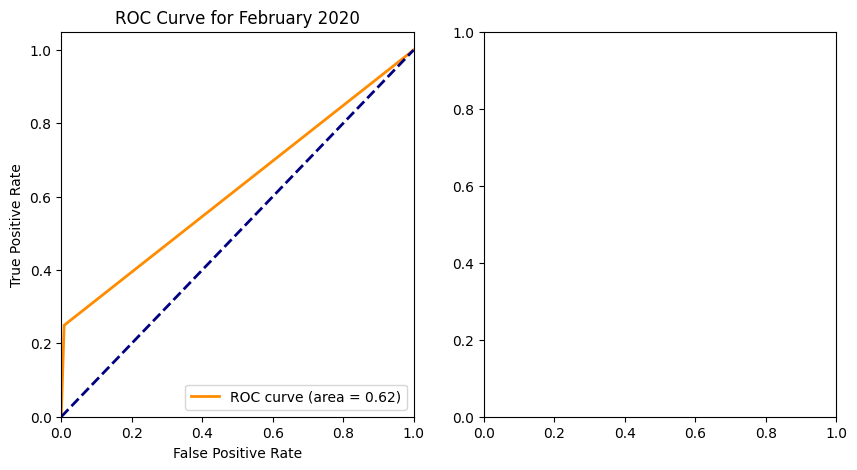

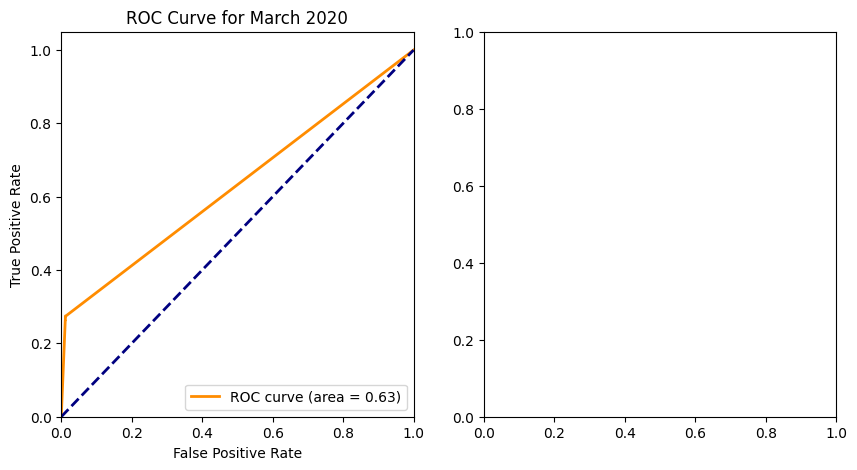

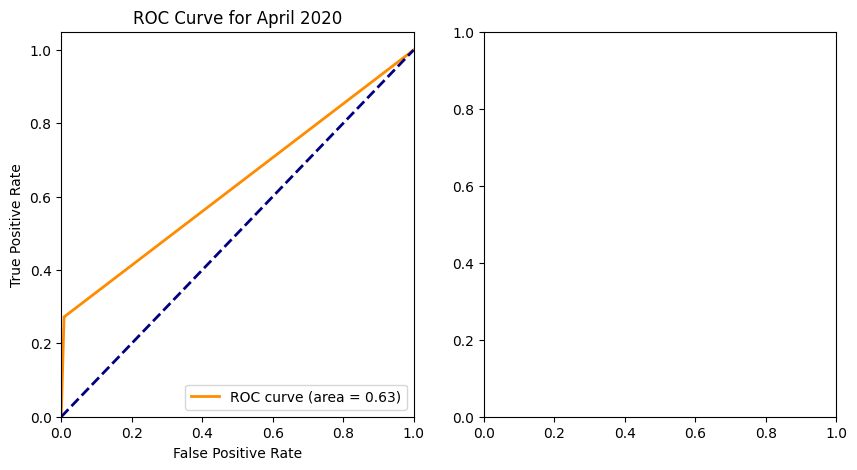

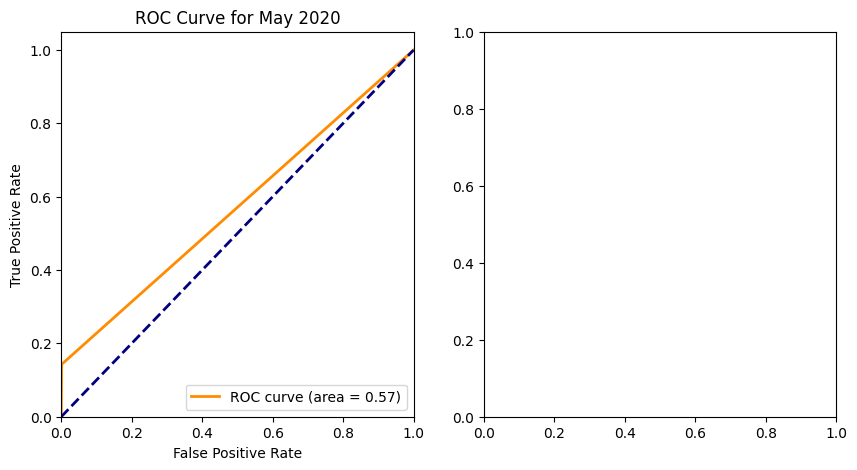

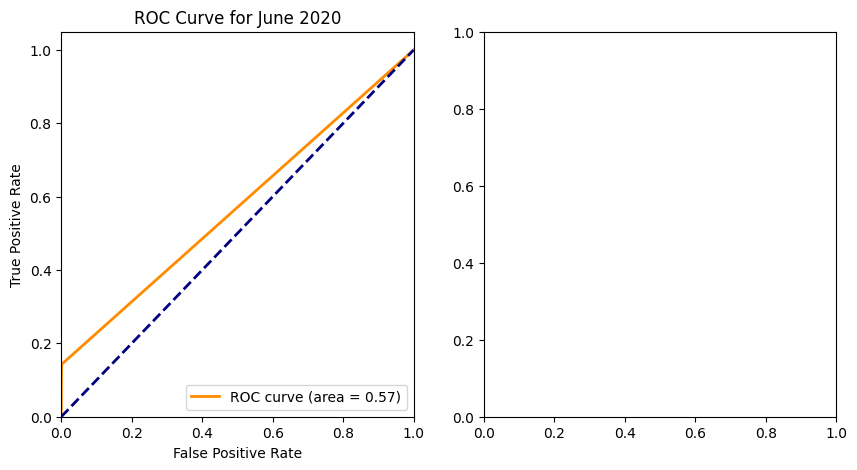

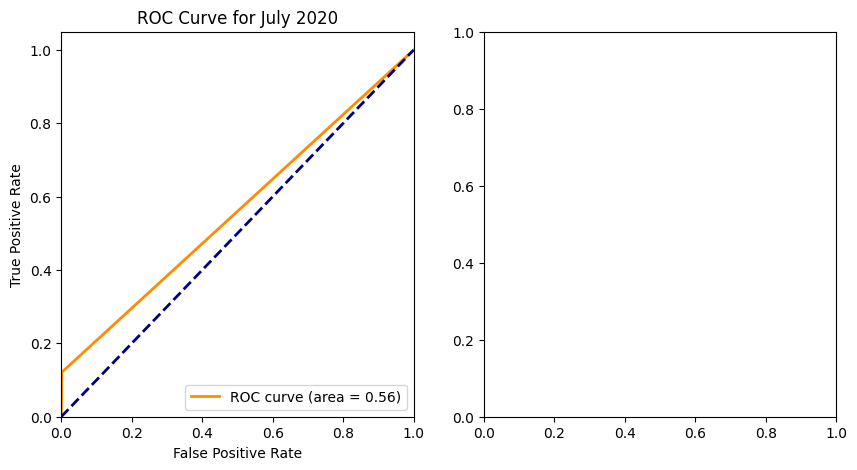

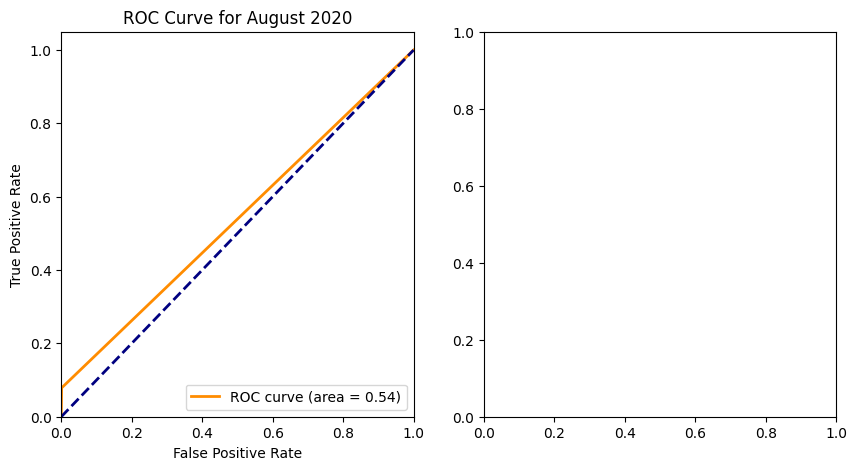

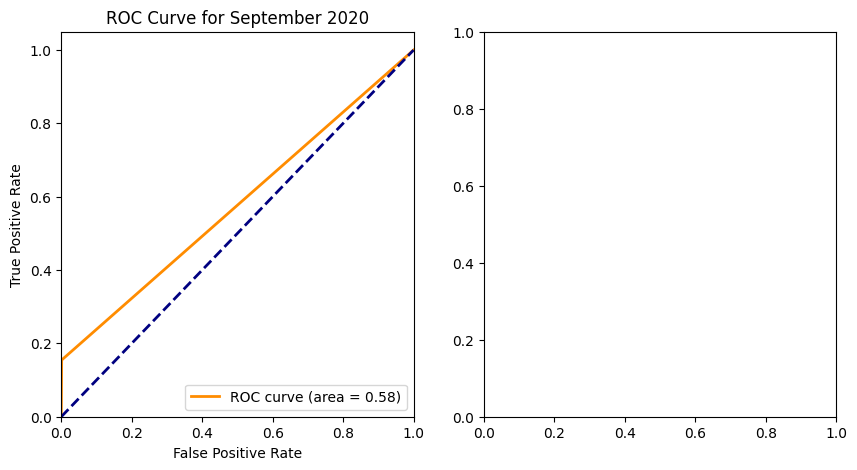

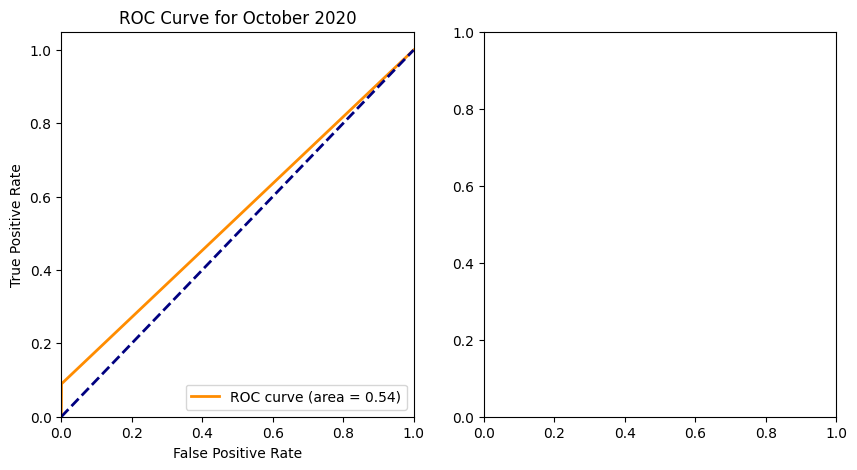

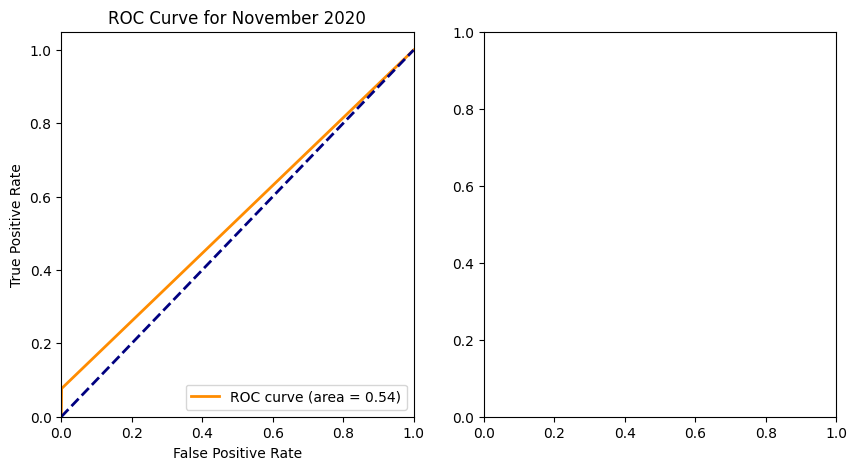

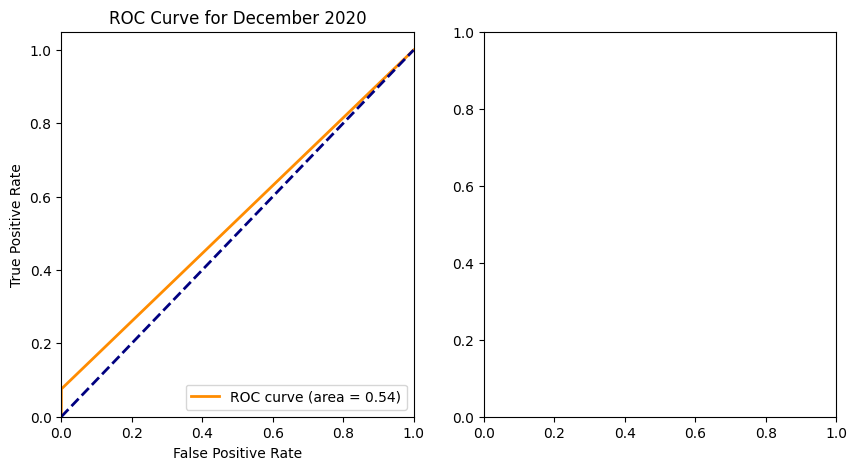

In [64]:
# Parámetros de LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1
}

lgb_model = None
folder_path = 'model_performance_charts'
metrics_file_path = os.path.join(folder_path, 'model_metrics.txt')

# Asegurarse de que la carpeta está limpia
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
os.makedirs(folder_path)

# Abrir archivo de texto para escribir las métricas
with open(metrics_file_path, 'w') as metrics_file:
    # Iterar sobre cada segmento mensual y entrenar modelos
    for name, month_data in monthly_datasets.items():
        print(f"Entrenando con datos de: {name}")

        # Dividir los datos en entrenamiento y validación
        X = month_data.drop(['is_fraud'], axis=1)
        y = month_data['is_fraud']
        X_train_month, X_val_month, y_train_month, y_val_month = train_test_split(
            X, y, test_size=0.2, random_state=42)

        train_data_month = lgb.Dataset(X_train_month, label=y_train_month)
        valid_data_month = lgb.Dataset(X_val_month, label=y_val_month)

        # Entrenamiento con validación
        if lgb_model is None:
            lgb_model = lgb.train(
                params,
                train_data_month,
                num_boost_round=100,
                valid_sets=[valid_data_month],
                valid_names=['validation']
            )
        else:
            lgb_model = lgb.train(
                params,
                train_data_month,
                init_model=lgb_model,
                num_boost_round=10,
                valid_sets=[valid_data_month],
                valid_names=['validation']
            )

        # Predecir en el conjunto de validación
        y_pred = lgb_model.predict(X_val_month, num_iteration=lgb_model.best_iteration)
        y_pred_binary = (y_pred >= 0.5).astype(int)

        # Métricas adicionales
        f1 = f1_score(y_val_month, y_pred_binary)
        cm = confusion_matrix(y_val_month, y_pred_binary)

        # Graficar ROC
        fpr, tpr, _ = roc_curve(y_val_month, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name.strftime("%B %Y")}')
        plt.legend(loc="lower right")
        plt.savefig(f"{folder_path}/roc_curve_{name.strftime('%Y_%m')}.png")

        # Graficar matriz de confusión
        plt.subplot(1, 2, 2)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name.strftime("%B %Y")}')
        plt.savefig(f"{folder_path}/conf_matrix_{name.strftime('%Y_%m')}.png")
        plt.close()

        # Escribir métricas al archivo de texto
        metrics_file.write(f'F1 Score for {name.strftime("%B %Y")}: {f1:.2f}\n')
        metrics_file.write(f'Confusion Matrix for {name.strftime("%B %Y")}:\n{cm}\n\n')

print("Revisa la carpeta 'model_performance_charts' para ver el desempeño de los modelos.")


-------------------------------------------

Tipos de datos para el mes: 2020-12
amt                             float64
lat                             float64
long                            float64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
amt_month                       float64
amt_year                        float64
amt_month_shopping_net_spend    float64
count_month_shopping_net        float64
first_time_at_merchant            int32
time_since_last_txn             float64
avg_daily_amt                   float64
hour                              int64
avg_hourly_transactions         float64
prev_lat                        float64
prev_long                       float64
distance_from_last_txn          float64
monthly_spending_variation      float64
weekday                           int64
is_holiday                        int32
days_since_first_txn              int64
txn_count_last_24h              float64
avg_amt_last_24h                float64
std_amt_last_24h                float64
online_txn_ratio                float64
monthly_txn_count_by_cat          int64
trans_year                        int64
yearly_txn_count_by_cat           int64
seasonal_txn_count_by_cat         int64
time_diff_hours                 float64
transaction_speed               float64
amt_to_daily_avg                float64
amt_to_monthly_avg              float64
txn_count_last_hour             float64
new_merchant                      int32
amt_to_annual_avg               float64
merchant_encoded                  int32
category_encoded                  int32
season_encoded                    int32
dtype: object

-------------------------------------------